In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

# Import the cross-validation tool
from sklearn.model_selection import cross_val_score

In [2]:
# Load the data, keeping the features (X) and target (y) separated
iris = load_iris(as_frame=True)
x, y = iris.data, iris.target

print(f"Total samples: {len(x)}")

Total samples: 150


In [3]:
# Instantiate the model
logreg = LogisticRegression(max_iter=200)

print("Logistic Regression model instantiated.")

Logistic Regression model instantiated.


In [4]:
# Perform 5-Fold Cross-Validation (CV)
# cv=5 means 5 folds. The scoring='accuracy' tells it what metric to return.
cv_scores = cross_val_score(
    estimator=logreg, # The model to use
    X=x,              # The FULL feature set (CV handles the splitting)
    y=y,              # The FULL target set
    cv=5,             # Number of folds
    scoring='accuracy'
)

print("Individual Cross-Validation Scores (5 Folds):")
print(cv_scores)

Individual Cross-Validation Scores (5 Folds):
[0.96666667 1.         0.93333333 0.96666667 1.        ]


In [5]:
# Calculate the mean (average performance)
mean_cv_score = np.mean(cv_scores)

# Calculate the standard deviation (measure of variability/robustness)
std_cv_score = np.std(cv_scores)

print(f"\nMean CV Accuracy: {mean_cv_score:.4f}")
print(f"Standard Deviation of CV Scores: {std_cv_score:.4f}")


Mean CV Accuracy: 0.9733
Standard Deviation of CV Scores: 0.0249


In [6]:
## Mean accuracy = High, therefore model is relatively accurate
## Std Dev = Low, therefore model is precise i.e. repeatable

In [7]:
# Import the remaining classifiers needed for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # Adding KNN back for full comparison

# Instantiate all the models you want to test
models = [
    ('Logistic Regression', LogisticRegression(max_iter=200, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('SVC', SVC(random_state=42))
]

# Initialize a list to store the results
cv_results = []

In [8]:
# Perform 5-Fold CV for each model
for name, model in models:
    # Use cross_val_score
    cv_scores = cross_val_score(
        estimator = model,
        X = x,
        y = y,
        cv = 5,
        scoring='accuracy'
    )
    # Store the avg score and std.dev
    cv_results.append({
        'Model': name,
        'Mean CV Accuracy': np.mean(cv_scores),
        'STD': np.std(cv_scores)
    })

    print(f"Completed CV for: {name}")

print("\nAll CV runs complete.")


Completed CV for: Logistic Regression
Completed CV for: KNN
Completed CV for: Random Forest
Completed CV for: SVC

All CV runs complete.


In [9]:
# Create the comparison table
cv_summary_df = pd.DataFrame(cv_results)

# Format the results for better readability and sort by accuracy
cv_summary_df['Mean CV Accuracy'] = cv_summary_df['Mean CV Accuracy'].map('{:.4f}'.format)
cv_summary_df['STD'] = cv_summary_df['STD'].map('{:.4f}'.format)
cv_summary_df = cv_summary_df.sort_values(by='Mean CV Accuracy', ascending=False)

print("--- Cross-Validation Model Comparison ---")
print(cv_summary_df)

--- Cross-Validation Model Comparison ---
                 Model Mean CV Accuracy     STD
0  Logistic Regression           0.9733  0.0249
1                  KNN           0.9667  0.0211
2        Random Forest           0.9667  0.0211
3                  SVC           0.9667  0.0211


In [10]:
# Import the tuning tool
from sklearn.model_selection import GridSearchCV

# Import the model we are tuning (SVC)
from sklearn.svm import SVC

In [11]:
# Define the parameter grid (all combinations of these values will be tested)
param_grid = {
    # Test C values
    'C' : [0.1, 1, 10, 100],
    # Test gamma values
    'gamma': [1, 0.1, 0.01, 0.001],
    # We will only use the Radial Basis Function (RBF) kernel
    'kernel': ['rbf']
}

print("Parameter grid defined. testing 4 * 4 * 1 = 16 combinations.")

Parameter grid defined. testing 4 * 4 * 1 = 16 combinations.


In [12]:
# Instantiate the SVC model
svc_base = SVC(random_state=42)

#Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator = svc_base,
    param_grid = param_grid,
    scoring = 'accuracy', # Metric to optimize
    cv = 5,              # Use 5-Fold Cross-Validation
    verbose = 3,         # Shows progress output during the long run
    n_jobs = -1          # Use all available CPU cores
)

In [13]:
grid_search.fit(x,y)

print("\nGrid Search Completed.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Grid Search Completed.


In [14]:
# Get highest score
best_score = grid_search.best_score_
print(f"Best Mean CV Accuracy found: {best_score:.4f}")

# Get the combination of settings with highest score
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Store the final, best-tuned model
best_model = grid_search.best_estimator_

Best Mean CV Accuracy found: 0.9800
Best Hyperparameters:
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [15]:
# Convert cv results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Keep only columns we care about
viz_data = results_df[['param_C', 'param_gamma', 'mean_test_score']]

# Pivot so C is one axis and Gamma is the other
heatmap_data = viz_data.pivot(index='param_C', columns='param_gamma', values='mean_test_score')
display(heatmap_data)

param_gamma,0.001,0.010,0.100,1.000
param_C,,,,
0.1,0.913333,0.913333,0.920000,0.960000
1.0,0.913333,0.933333,0.980000,0.966667
10.0,0.933333,0.980000,0.980000,0.953333
100.0,0.980000,0.980000,0.966667,0.940000


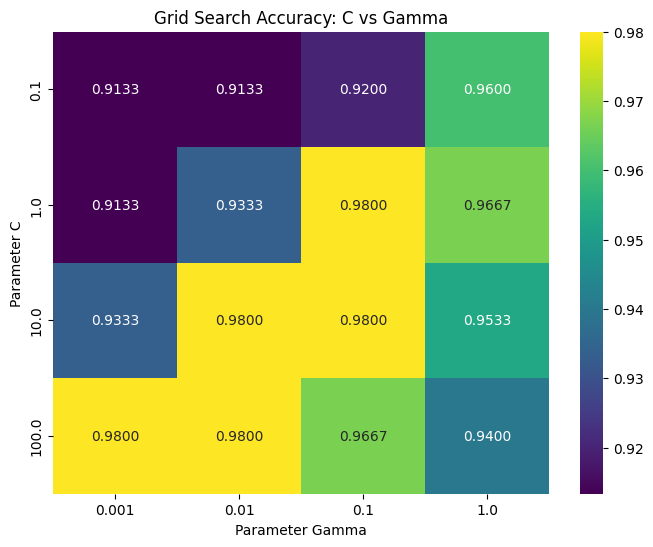

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f')

plt.title('Grid Search Accuracy: C vs Gamma')
plt.ylabel('Parameter C')
plt.xlabel('Parameter Gamma')
plt.show()

In [17]:
untuned_score = mean_cv_score

print(f"Untuned SVC Accuracy: {untuned_score:.4f}")
print(f"Tuned SVC Accuracy: {grid_search.best_score_:.4f}")
print(f"Accuracy Improvement: {grid_search.best_score_ - untuned_score:.4f}")

Untuned SVC Accuracy: 0.9733
Tuned SVC Accuracy: 0.9800
Accuracy Improvement: 0.0067


In [18]:
## Executive Summary
# Best Model = SVC
# Best Parameters = C : 1, Gamma = 0.1
# Iris data is "solved"

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 1. Create a clean split (70% train / 30% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 2. Re-fit the best model on the training portion
best_tuned_model = grid_search.best_estimator_
best_tuned_model.fit(X_train, y_train)

# 3. Get predictions on the test set
y_pred = best_tuned_model.predict(X_test)


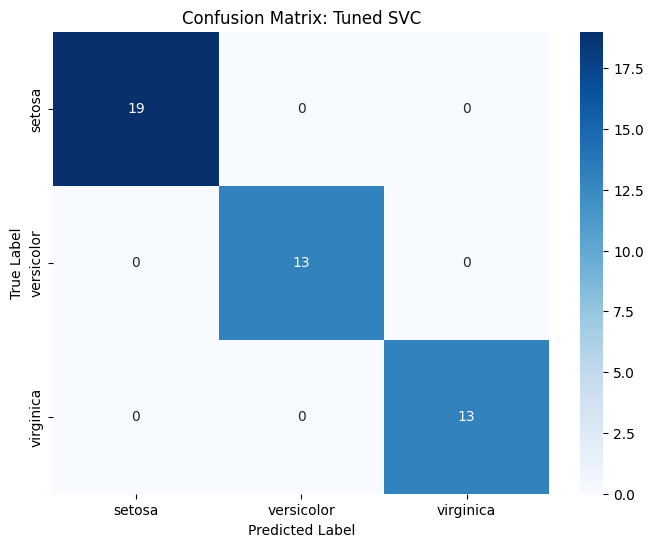

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Tuned SVC')
plt.show()

In [22]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

--- Classification Report ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

